# NLP-Based Topic Extraction of Consumer Complaints

This notebook demonstrates an NLP pipeline for extracting recurring themes from unstructured consumer complaint narratives. The analysis follows an exploratory yet systematic approach, progressing from raw text preprocessing to topic modeling using two methods (LDA and NMF).

Each section can be executed independently provided the required intermediate artefacts are available.

## Setup

Load required libraries, define utility functions, and configure project paths.

Notes:
 - This section must be executed before any other section.
 - External dependencies include pandas, spaCy, scikit-learn, and matplotlib.

In [4]:
# Imports
import ast
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# Utility function to get the project root directory
def get_project_root():
    '''
    Returns the root directory of the project.
    '''
    try:
        return Path(__file__).resolve().parents[1]
    except NameError:
        return Path.cwd().parent

In [6]:
# Define the path to the data file
project_root = get_project_root()
data_file = project_root / "data" / "complaints.csv"

## Section 1

### 1.1 Data Loading and Initial Filtering

Load the raw complaint dataset and restrict analysis to narrative text suitable for NLP.

Key steps:
 - Load CSV file
 - Retain complaint narrative column
 - Remove missing values and duplicates

In [7]:
# Load the complaints data
df_complaints = pd.read_csv(project_root / "data" / "complaints.csv")
print("Loaded: complaints.csv as df_complaints")

Loaded: complaints.csv as df_complaints


In [8]:
df_complaints.shape

(12847822, 18)

In [9]:
df_complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-11-25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30311,NaN,NaN,Web,2025-11-25,In progress,Yes,NaN,17487731
2,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,My credit report contains incorrect and mislea...,NaN,"EQUIFAX, INC.",TX,75062,NaN,Consent provided,Web,2025-10-14,Closed with non-monetary relief,Yes,NaN,16558024
3,2025-10-26,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,Be sure that disputed accounts are taken down ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,93619,NaN,Consent provided,Web,2025-10-26,Closed with non-monetary relief,Yes,NaN,16826857
4,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,Consent not provided,Web,2025-10-10,Closed with non-monetary relief,Yes,NaN,16507707


In [10]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12847822 entries, 0 to 12847821
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.

In [11]:
df_complaints.nunique()

Date received                       5149
Product                               21
Sub-product                           86
Issue                                178
Sub-issue                            272
Consumer complaint narrative     2433940
Company public response               11
Company                             7806
State                                 63
ZIP code                           35711
Tags                                   3
Consumer consent provided?             4
Submitted via                          7
Date sent to company                5098
Company response to consumer           8
Timely response?                       2
Consumer disputed?                     2
Complaint ID                    12847822
dtype: int64

In [12]:
# Focus on the 'Consumer complaint narrative' column
# Drop rows with missing values in 'Consumer complaint narrative'
df_complaints = df_complaints.loc[:, df_complaints.columns.intersection(['Consumer complaint narrative'])]
df_complaints = df_complaints.dropna(subset=['Consumer complaint narrative'])

In [13]:
df_complaints = df_complaints.drop_duplicates()


### 1.2 Sampling and Length-Based Filtering

Reduce dataset size for computational feasibility and remove complaints that are too short to provide meaningful thematic information.

Key steps:
 - Random sampling for exploration
 - Word-count calculation
 - Empirical threshold selection (>30 words)
 - Final sampling to 10,000 complaints

In [14]:
# Create a random sample of 20,000 complaints for exploration
df_sample = df_complaints.sample(n=20000, random_state=42)

In [15]:
# Add a new column 'word_count' to count the number of words in each complaint narrative
df_sample['word_count'] = df_sample['Consumer complaint narrative'].str.split().str.len()

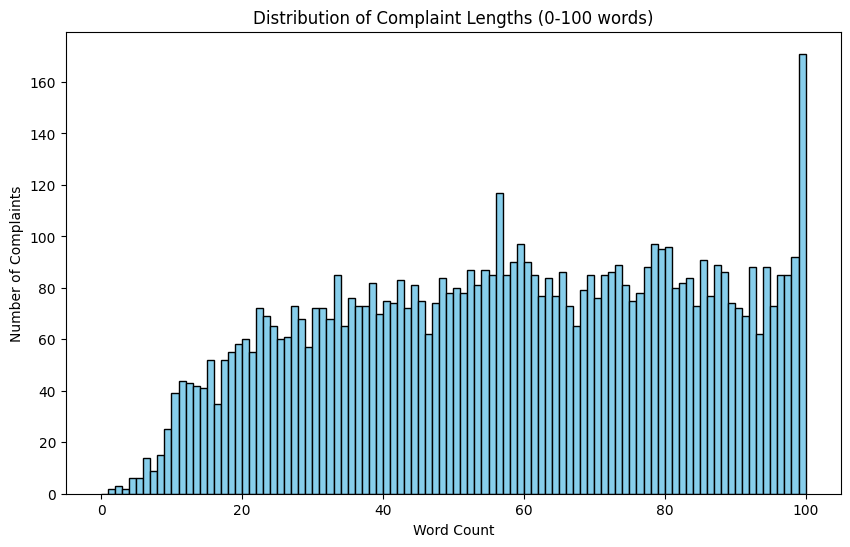

In [16]:
# Visualize the distribution of short complaints
plt.figure(figsize=(10, 6))
plt.hist(df_sample['word_count'], bins=100, range=(0, 100), color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Lengths (0-100 words)')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.show()

In [17]:
# Apply a filter to keep only complaints with > 30 words based on the histogram observation
df_sample = df_sample[df_sample['word_count'] > 30].copy()

print(f"Remaining rows after filtering: {len(df_sample)}")


Remaining rows after filtering: 18745


In [18]:
# Resample to get 10,000 complaints (chosen to balance topic stability and runtime) for further analysis
df_sample = df_sample.sample(n=10000, random_state=42)

# Save sample for further analysis
df_sample.to_pickle(project_root / "data" / "complaints_sample.pkl")
print("Saved: complaints_sample.pkl")

Saved: complaints_sample.pkl


## Section 2

### 2.1 Exploratory Word Frequency Analysis

Gain a preliminary understanding of dominant terms and noise patterns in the raw text.

Key steps:
 - Tokenization via simple string splitting
 - Frequency counting using Counter
 - Inspection of most common words

In [19]:
# Read the sample back in
df_sample = pd.read_pickle(project_root / "data" / "complaints_sample.pkl")
print("Loaded: complaints_sample.pkl as df_sample")

Loaded: complaints_sample.pkl as df_sample


In [20]:
# Join a sample of text and split into words to count word frequencies
all_words = ' '.join(df_sample['Consumer complaint narrative']).lower().split()
word_counts = Counter(all_words)

# Look at the top 100 most common words
print(word_counts.most_common(100))

[('xxxx', 152062), ('the', 85536), ('to', 67213), ('i', 59611), ('and', 55540), ('of', 43381), ('my', 42986), ('a', 42364), ('that', 28307), ('this', 23518), ('in', 22074), ('credit', 21999), ('on', 20770), ('(', 19913), ('is', 19897), ('was', 18828), ('not', 18777), ('have', 18045), (':', 16573), ('for', 16402), ('account', 16371), ('with', 16106), (')', 15650), ('they', 15355), ('as', 12304), ('me', 12134), ('or', 11894), ('from', 11691), ('it', 11535), ('information', 11235), ('be', 9851), ('reporting', 9768), ('consumer', 9192), ('any', 9128), ('are', 8434), ('by', 8360), ('report', 8289), ('xxxx,', 8015), ('you', 7759), ('xx/xx/xxxx', 7744), ('has', 7616), ('an', 6922), ('15', 6375), ('am', 6334), ('been', 5998), ('all', 5967), ('these', 5819), ('which', 5706), ('no', 5617), ('xxxx.', 5400), ('had', 5382), ('payment', 4986), ('accounts', 4875), ('under', 4866), ('debt', 4670), ('but', 4627), ('if', 4619), ('your', 4619), ('at', 4551), ('would', 4284), ('them', 4047), ('balance', 4

### 2.2 Text Cleaning and Lemmatization

Transform raw complaint narratives into linguistically normalized tokens suitable for vectorization.

Key steps:
 - Lowercasing
 - Removal of redaction placeholders and numerical noise
 - Lemmatization using spaCy
 - Stopword and short-token filtering

In [21]:
# Load the small English model in spaCy (disable NER and parser for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

def clean_and_lemmatize(text):
    '''
    Clean and lemmatize the input text
    Args:
        text (str): The input text to be cleaned and lemmatized
    Returns:
        list: A list of cleaned and lemmatized tokens
    '''
    # Lowercase
    text = text.lower()
    
    # Noise Removal
    text = re.sub(r'x{2,}', '', text) # Removes XXXX (most common based on previous analysis)
    text = re.sub(r'\d+', '', text) # Removes all numbers
    text = re.sub(r'/+', '', text) # Removes slashes
    text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatization and filtering
    tokens = [
        token.lemma_ for token in doc # Lemmatize
        if token.is_alpha # Keep only alphabetic tokens
        and len(token.lemma_) > 2 # Filter out short tokens
        and token.lemma_.lower() not in nlp.Defaults.stop_words # Remove stop words
    ]
    
    return tokens

# Apply to filtered sample
df_cleaned_sample = df_sample.copy()
df_cleaned_sample['tokens'] = df_cleaned_sample['Consumer complaint narrative'].apply(clean_and_lemmatize)

In [22]:
# Save cleaned sample data for further analysis
df_cleaned_sample.to_pickle(project_root / "data" / "complaints_sample_cleaned.pkl")
print("Saved: complaints_sample_cleaned.pkl")

Saved: complaints_sample_cleaned.pkl


## Section 3

### 3.1 Post-Cleaning Token Inspection

Verify the effectiveness of preprocessing and ensure meaningful tokens remain.

Key steps:
 - Aggregate cleaned tokens
 - Inspect most frequent lemmatized terms

In [23]:
# Read the cleaned sample back in
df_cleaned_sample = pd.read_pickle(project_root / "data" / "complaints_sample_cleaned.pkl")
print("Loaded: complaints_sample_cleaned.pkl as df_cleaned_sample")

Loaded: complaints_sample_cleaned.pkl as df_cleaned_sample


In [24]:
df_cleaned_sample.head()

,Consumer complaint narrative,word_count,tokens
10095914,"They first put my account on restriction, then...",31,"[account, restriction, randomly, close, accoun..."
4924570,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, ...",292,"[louisiana, experian, department, box, subject..."
11461705,I have submitted multiple disputes regarding t...,115,"[submit, multiple, dispute, regard, account, b..."
235776,"Between XX/XX/year> and XX/XX/year>, I was the...",239,"[year, year, victim, coercionextortion, scam, ..."
938334,THESE 3 COMPANIES ARE ON MY CREDIT REPORT AND ...,124,"[company, credit, report, clearly, belong, att..."


In [25]:
# List of top 100 tokens in cleaned sample
all_cleaned_tokens = [token for tokens in df_cleaned_sample['tokens'] for token in tokens]
cleaned_word_counts = Counter(all_cleaned_tokens)
print(cleaned_word_counts.most_common(100))

[('account', 25233), ('credit', 23052), ('report', 19930), ('information', 13456), ('consumer', 10797), ('payment', 8984), ('reporting', 7613), ('dispute', 6432), ('debt', 6315), ('request', 6189), ('date', 5287), ('receive', 5275), ('provide', 5059), ('pay', 4994), ('time', 4871), ('agency', 4802), ('balance', 4736), ('day', 4618), ('number', 4584), ('state', 4555), ('send', 4536), ('remove', 4525), ('loan', 4488), ('file', 4482), ('bank', 4371), ('company', 4153), ('card', 4140), ('right', 4087), ('section', 4056), ('charge', 4041), ('tell', 3952), ('inquiry', 3843), ('open', 3764), ('fcra', 3730), ('act', 3718), ('collection', 3679), ('inaccurate', 3606), ('item', 3536), ('letter', 3490), ('late', 3475), ('year', 3352), ('write', 3250), ('complaint', 3231), ('identity', 3220), ('address', 3011), ('law', 2941), ('violation', 2925), ('contact', 2910), ('fair', 2897), ('follow', 2836), ('theft', 2798), ('use', 2760), ('fraudulent', 2757), ('ask', 2686), ('issue', 2630), ('creditor', 25

### 3.2 Text Reconstruction for Vectorization

Convert token lists back into cleaned text strings for compatibility with scikit-learn vectorizers.

Key steps:
 - Join tokens into space-separated strings
 - Create clean_text column

In [32]:
# Join tokens back into cleaned text for vectorization
df_cleaned_sample["clean_text"] = df_cleaned_sample["tokens"].apply(
    lambda tokens: " ".join(tokens)
)

In [33]:
df_cleaned_sample["clean_text"].head()

10095914    account restriction randomly close account fil...
4924570     louisiana experian department box subject disp...
11461705    submit multiple dispute regard account belong ...
235776      year year victim coercionextortion scam involv...
938334      company credit report clearly belong attach su...
Name: clean_text, dtype: object

In [34]:
texts = df_cleaned_sample["clean_text"].copy()

### 3.3 Feature Extraction (Vectorization)

Transform cleaned text into numerical representations for topic modeling.

Methods used:
 - Bag-of-Words (CountVectorizer)
 - TF-IDF (TfidfVectorizer)

In [35]:
# Vectorization using Bag-of-Words and TF-IDF
vectorizer_params = {
    "ngram_range": (1, 2), # Unigrams and bigrams
    "min_df": 5, # Minimum document frequency
    "max_df": 0.9 # Maximum document frequency
}

# Bag-of-Words and TF-IDF vectorization
bow_vectorizer = CountVectorizer(**vectorizer_params)
tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)

# Fit and transform the text data
bow_matrix = bow_vectorizer.fit_transform(texts)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

In [36]:
# Check the shape of the resulting matrices
bow_matrix.shape, tfidf_matrix.shape

((10000, 26886), (10000, 26886))

In [37]:
# Get feature names from Bag-of-Words vectorizer
feature_names = np.array(bow_vectorizer.get_feature_names_out())

# Get the first 20 n-grams (bigrams)
ngrams = [f for f in feature_names if " " in f][:20]
ngrams

['abide accuracy',
 'abide law',
 'ability access',
 'ability maximum',
 'ability obtain',
 'ability pay',
 'ability qualify',
 'ability recovery',
 'ability secure',
 'able access',
 'able acquire',
 'able answer',
 'able apply',
 'able assist',
 'able close',
 'able complete',
 'able confirm',
 'able contact',
 'able explain',
 'able find']

### 3.4 Topic Modeling

Extract latent themes from complaint narratives using probabilistic and matrix-factorization approaches.

Models applied:
 - Latent Dirichlet Allocation (LDA) on BoW features
 - Non-negative Matrix Factorization (NMF) on TF-IDF features

Exploration strategy:
 - Multiple topic counts tested (4, 5, 8)
 - Qualitative comparison of topic coherence and interpretability

In [38]:
def display_topics(model, feature_names, n_top_words=10):
    ''' Display the top words for each topic in the given model.
    Args:
        model: The topic modeling model (LDA or NMF)
        feature_names: Array of feature names from the vectorizer
        n_top_words: Number of top words to display for each topic
    '''
    for topic_idx, topic in enumerate(model.components_):
        top_words = feature_names[topic.argsort()[-n_top_words:][::-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

In [39]:
def run_topic_models(text_matrix_bow, text_matrix_tfidf, vectorizer_bow, vectorizer_tfidf, n_topics_list):
    ''' Run LDA and NMF topic models for different numbers of topics.
    Args:
        text_matrix_bow: Document-term matrix from Bag-of-Words vectorization
        text_matrix_tfidf: Document-term matrix from TF-IDF vectorization
        vectorizer_bow: Fitted Bag-of-Words vectorizer
        vectorizer_tfidf: Fitted TF-IDF vectorizer
        n_topics_list: List of integers specifying the number of topics to model'''
    for n_topics in n_topics_list:
        print(f"\n--- {n_topics} topics ---")

        # LDA
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            learning_method="batch" # better for smaller datasets
        )
        lda.fit(text_matrix_bow)
        print("LDA Topics:")
        display_topics(lda, vectorizer_bow.get_feature_names_out(), n_top_words=10)

        # NMF
        nmf = NMF(
            n_components=n_topics,
            random_state=42,
            init="nndsvd"
        )
        nmf.fit(text_matrix_tfidf)
        print("NMF Topics:")
        display_topics(nmf, vectorizer_tfidf.get_feature_names_out(), n_top_words=10)

### 3.5 Topic Inspection and Comparison

Compare topic structures across models and topic counts to assess interpretability and thematic resolution.

In [40]:
# Run topic models for 4, 5, and 8 topics for exploration
run_topic_models(bow_matrix, tfidf_matrix, bow_vectorizer, tfidf_vectorizer, [4, 5, 8])


--- 4 topics ---
LDA Topics:
Topic 1: account, consumer, credit, report, information, inquiry, reporting, section, agency, identity
Topic 2: report, credit, account, information, credit report, reporting, dispute, consumer, debt, request
Topic 3: payment, credit, card, account, loan, bank, pay, charge, late, time
Topic 4: account, send, debt, receive, tell, company, pay, time, credit, letter
NMF Topics:
Topic 1: report, credit, information, credit report, account, dispute, debt, reporting, remove, fcra
Topic 2: section, consumer, reporting, consumer reporting, right, section state, reporting agency, agency, right privacy, state consumer
Topic 3: payment, account, bank, pay, loan, card, tell, time, receive, charge
Topic 4: theft, identity theft, inquiry, identity, hard inquiry, hard, fraudulent, result, account, result identity

--- 5 topics ---
LDA Topics:
Topic 1: account, credit, report, inquiry, credit report, identity, theft, information, identity theft, remove
Topic 2: report, cr